## Машинное обучение

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

# Data preprocessing
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Clustering
from sklearn.cluster import DBSCAN

# Model selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

# Evaluation metrics
from sklearn.metrics import silhouette_score

# CatBoost
!pip3 install catboost
import catboost
from catboost import CatBoostRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Загрузка данных

In [62]:
csv_file_path = "df_encoded.csv"
df_encoded = pd.read_csv(csv_file_path)

In [63]:
# Отсортируем значения по колонке Price
df_encoded = df_encoded.sort_values(by='Price')
df_encoded.reset_index(drop=True, inplace=True)

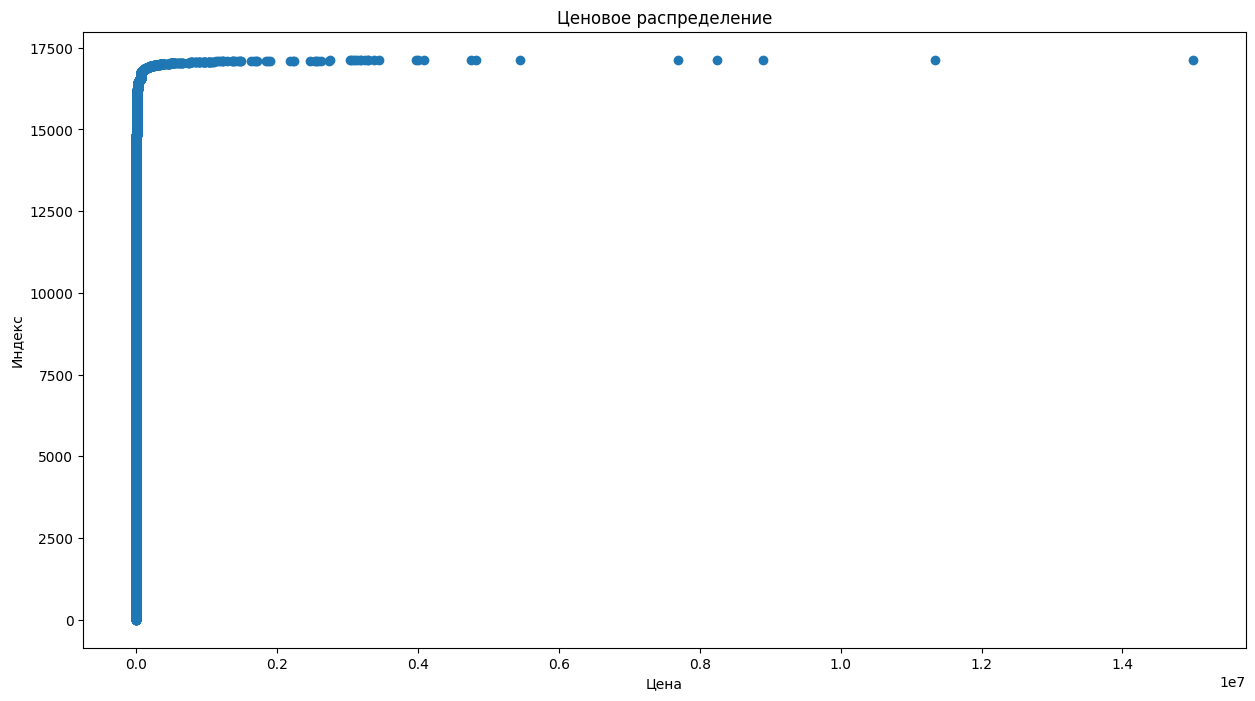

In [64]:
# Создание scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(df_encoded['Price'], df_encoded.index)

plt.xlabel('Цена')
plt.ylabel('Индекс')
plt.title('Ценовое распределение')

plt.show()

In [65]:
X = df_encoded.drop(['Name', 'Price'], axis=1).reset_index(drop = True)
y = df_encoded['Price'].reset_index(drop = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Выбор модели
- Из распределения цены видно, что линейная модель точно не сможет описать ее логику с большой точностью
- Помимо линейной регрессии у нас остается выбор между решающим деревом, случайным лесом и градиентным бустингом
- Мы рассмотрим **несколько моделей градиентного бустинга**, так как он использует итеративное улучшение с каждым шагом и способен лучше обучиться

### Кластеризация
- Проверим теорию, что кластеризация и добавление признака, показывающего, к какому кластеру относится объект, поможет модели лучше предсказывать цену игрока

#### Посмотрим на MAE без кластеризации

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [67]:
# Отмасштабируем данные
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [68]:
# Используем градиентный бустинг
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)

y_pred_train = gb.predict(X_train)
MAE = mean_absolute_error(y_train, y_pred_train)

print(f'Train MAE {MAE}')

Train MAE 6471.827217227958


#### Посмотрим на MAE c кластеризацией

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [115]:
# Отмасштабируем данные
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

In [80]:
# Определение гиперпараметров для перебора
param_grid = {'eps': [0.3, 0.5, 1], 'min_samples': [2, 3, 30]}

best_score = -1
best_params = {}

# Перебор по всем комбинациям гиперпараметров
for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(**params)
    dbscan.fit(X_train)
    labels = dbscan.labels_
    unique_labels = np.unique(labels)

    # Проверка, что есть более одного кластера
    if len(unique_labels) > 1:
        silhouette_avg = silhouette_score(X_train, labels)
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            best_params = params

# Получение оптимальных гиперпараметров
best_eps = best_params['eps']
best_min_samples = best_params['min_samples']

# Создание и обучение DBSCAN с оптимальными гиперпараметрами
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan.fit(X_train)

# Получение меток кластеров для обучающих данных
cluster_labels = dbscan.labels_

In [82]:
X_train = np.concatenate((X_train, cluster_labels.reshape(-1, 1)), axis=1)

cluster_labels_test = dbscan.fit_predict(X_test)

# Добавим признак принадлежности к ближайшему кластеру в X_test
X_test = np.concatenate((X_test, cluster_labels_test.reshape(-1, 1)), axis=1)

In [85]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)

y_pred_train = gb.predict(X_train)
y_pred_test = gb.predict(X_test)

MAE_train = mean_absolute_error(y_train, y_pred_train)
MAE_test = mean_absolute_error(y_pred_test, y_test)

print(f'Train MAE with clastering feature {MAE_train}')
print(f'Test MAE with clastering feature {MAE_test}')

Train MAE with clastering feature 6644.638217576036
Test MAE with clastering feature 13437.482637973599


- Включение нового признака, который отражает принадлежность объекта к определенному кластеру, не привело к улучшению качества модели. Поэтому мы будем использовать наборы данных X_train и X_test без этого признака

### Отбор признаков

- Правильный отбор самых важных признаков позволит нам без потери качества многократно увеличить скорость обучения модели
- Train MAE без отбора признаков в прошлом пункте составил 5755

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [100]:
from sklearn.metrics import mean_absolute_error

max_features = [25, 50, 75]
train_errors = []
test_errors = []

for num in max_features:
    # Отбор num важных признаков с использованием градиентного бустинга
    selector = SelectFromModel(gb, max_features=num)
    selector.fit(X_train, y_train)

    # Фильтрация данных
    X_train_important = selector.transform(X_train)
    X_test_important = selector.transform(X_test)

    # Обучение градиентного бустинга на num лучших признаках
    gb.fit(X_train_important, y_train)

    # Оценка качества на тренировочных данных
    y_pred_train = gb.predict(X_train_important)
    MAE_train = mean_absolute_error(y_train, y_pred_train)
    train_errors.append(MAE_train)

    # Оценка качества на тестовых данных
    y_pred_test = gb.predict(X_test_important)
    MAE_test = mean_absolute_error(y_test, y_pred_test)
    test_errors.append(MAE_test)

# Вывод результатов
for i, num in enumerate(max_features):
    print(f"Number of features: {num}")
    print(f"Train MAE: {train_errors[i]}")
    print(f"Test MAE: {test_errors[i]}")
    print("-------------------------")


Number of features: 25
Train MAE with clustering feature: 6742.938025575051
Test MAE with clustering feature: 11062.676702021961
-------------------------
Number of features: 50
Train MAE with clustering feature: 6389.7104335640915
Test MAE with clustering feature: 10867.769543887116
-------------------------
Number of features: 75
Train MAE with clustering feature: 6389.7104335640915
Test MAE with clustering feature: 10867.769543887116
-------------------------


- Модель не сильно просела по качеству, поэтомц мы будем использовать 50 признаков вместо 987 и ускорим обучение модели
- Мы могли бы использовать еще меньше признаков, но это с большой вероятностью приведет к переобучению, поэтому мы возьмем 50 признаков

In [120]:
# Проверим изменение качества при использовании 50 самых важных из 987 признаков
selector = SelectFromModel(gb, max_features = 50)
selector.fit(X_train, y_train)

# Фильтруем данные
X_train = selector.transform(X_train)

### Catboost

- Вместо использования обычного градиентного спуска мы применим алгоритм CatBoost, который строит симметричные предикаты, и оценим качество полученной модели

In [103]:
model = model = CatBoostRegressor()

model.fit(X_train, y_train)

# Смотрим на качество
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

MAE_train = mean_absolute_error(y_train, y_pred_train)
MAE_test = mean_absolute_error(y_pred_test, y_test)

print(f'Train MAE {MAE_train}')
print(f'Test MAE {MAE_test}')

Learning rate set to 0.061917
0:	learn: 255969.9968911	total: 22.2ms	remaining: 22.2s
1:	learn: 249844.1442102	total: 50.9ms	remaining: 25.4s
2:	learn: 243917.0735664	total: 67.7ms	remaining: 22.5s
3:	learn: 237397.8341211	total: 88.4ms	remaining: 22s
4:	learn: 232515.7720988	total: 127ms	remaining: 25.2s
5:	learn: 227453.8757442	total: 149ms	remaining: 24.6s
6:	learn: 222098.9497738	total: 188ms	remaining: 26.7s
7:	learn: 216478.1790886	total: 212ms	remaining: 26.2s
8:	learn: 211301.3863757	total: 233ms	remaining: 25.7s
9:	learn: 206602.5717035	total: 250ms	remaining: 24.8s
10:	learn: 202205.5008744	total: 265ms	remaining: 23.8s
11:	learn: 198277.4349616	total: 286ms	remaining: 23.5s
12:	learn: 194155.5343469	total: 309ms	remaining: 23.5s
13:	learn: 190076.1507671	total: 327ms	remaining: 23s
14:	learn: 186470.6436330	total: 344ms	remaining: 22.6s
15:	learn: 181802.8868773	total: 364ms	remaining: 22.4s
16:	learn: 178059.3489374	total: 380ms	remaining: 22s
17:	learn: 174381.5143791	tota

- Видно, что MAE гораздо более точен в своих предсказаниях, чем обычный градиентный бустинг на тренировочной выборке, но уступает не тестовой выборке --> Модель переобучилась
- Попробуем это исправить путем подбора гиперпараметров

In [106]:
# Подберем гиперпараметры глубины и l2 коэффициента с большим learning rate = 0.15, чтобы затем подобрать learning rate на оптимальной модели
param_grid = {
    'iterations': [30, 50, 150],
    'depth': [3, 15, 75],
    'learning_rate': [0.15],
    'l2_leaf_reg': [1, 3]
}

model = CatBoostRegressor(verbose=1)  # Добавляем verbose=1 для отслеживания прогресса

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Score (MAE):", -grid_search.best_score_)

0:	learn: 255546.4738068	total: 2.69ms	remaining: 78ms
1:	learn: 235117.6377985	total: 5.25ms	remaining: 73.5ms
2:	learn: 219201.6446803	total: 7.62ms	remaining: 68.6ms
3:	learn: 206520.6792565	total: 10ms	remaining: 65ms
4:	learn: 195931.3467005	total: 12.7ms	remaining: 63.4ms
5:	learn: 184979.3465636	total: 15.1ms	remaining: 60.4ms
6:	learn: 174121.1975219	total: 17.5ms	remaining: 57.6ms
7:	learn: 165894.5051650	total: 20.1ms	remaining: 55.4ms
8:	learn: 156967.9367023	total: 22.5ms	remaining: 52.6ms
9:	learn: 151901.6919500	total: 25.1ms	remaining: 50.3ms
10:	learn: 143199.0706593	total: 27.6ms	remaining: 47.7ms
11:	learn: 136596.7688693	total: 30.1ms	remaining: 45.1ms
12:	learn: 129690.2861183	total: 32.4ms	remaining: 42.4ms
13:	learn: 125089.0834933	total: 34.8ms	remaining: 39.8ms
14:	learn: 120992.8907211	total: 37.1ms	remaining: 37.1ms
15:	learn: 116610.5330856	total: 39.5ms	remaining: 34.5ms
16:	learn: 112061.1997354	total: 41.8ms	remaining: 31.9ms
17:	learn: 109059.0095059	tota

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 5734, in fit
    return self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline,
  File "/usr/local/lib/python3.10/dist-packages/catboost/core.py", line 2341, in _fit
    train_para

0:	learn: 241457.5874331	total: 1.14s	remaining: 2m 49s
1:	learn: 223193.1082271	total: 2.27s	remaining: 2m 48s
2:	learn: 206357.4802065	total: 3.42s	remaining: 2m 47s
3:	learn: 190373.4767851	total: 4.55s	remaining: 2m 46s
4:	learn: 173954.7918197	total: 5.08s	remaining: 2m 27s
5:	learn: 160891.9094978	total: 6.22s	remaining: 2m 29s
6:	learn: 148842.2882212	total: 7.36s	remaining: 2m 30s
7:	learn: 138016.5050592	total: 8.5s	remaining: 2m 30s
8:	learn: 127985.0440131	total: 9.98s	remaining: 2m 36s
9:	learn: 118485.9752209	total: 12s	remaining: 2m 47s
10:	learn: 109748.9416975	total: 13.1s	remaining: 2m 45s
11:	learn: 101360.3556097	total: 14.2s	remaining: 2m 43s
12:	learn: 93964.0713121	total: 15.4s	remaining: 2m 42s
13:	learn: 86818.6298446	total: 16.5s	remaining: 2m 40s
14:	learn: 80410.2486447	total: 17.7s	remaining: 2m 38s
15:	learn: 74586.9957923	total: 18.8s	remaining: 2m 37s
16:	learn: 68848.4385367	total: 20s	remaining: 2m 36s
17:	learn: 63815.3818276	total: 21.2s	remaining: 2m

In [117]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

model = CatBoostRegressor(iterations=150, depth=15, learning_rate=0.15, l2_leaf_reg=1)

# Обучаем модель на тренировочных данных
model.fit(X_train, y_train)

# Делаем предсказания на тренировочном и тестовом наборе данных
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Вычисляем MAE на тренировочных и тестовых данных
MAE_train = mean_absolute_error(y_train, y_pred_train)
MAE_test = mean_absolute_error(y_test, y_pred_test)

print(f'Train MAE: {MAE_train}')
print(f'Test MAE: {MAE_test}')


0:	learn: 241457.5874331	total: 2.19s	remaining: 5m 26s
1:	learn: 223193.1082271	total: 4.65s	remaining: 5m 44s
2:	learn: 206357.4802065	total: 5.78s	remaining: 4m 43s
3:	learn: 190373.4767851	total: 6.91s	remaining: 4m 12s
4:	learn: 173954.7918197	total: 7.5s	remaining: 3m 37s
5:	learn: 160891.9094978	total: 8.64s	remaining: 3m 27s
6:	learn: 148842.2882212	total: 9.78s	remaining: 3m 19s
7:	learn: 138016.5050592	total: 10.9s	remaining: 3m 13s
8:	learn: 127985.0440131	total: 12s	remaining: 3m 8s
9:	learn: 118485.9752209	total: 13.2s	remaining: 3m 4s
10:	learn: 109748.9416975	total: 14.4s	remaining: 3m 1s
11:	learn: 101360.3556097	total: 16.3s	remaining: 3m 7s
12:	learn: 93964.0713121	total: 18.4s	remaining: 3m 14s
13:	learn: 86818.6298446	total: 20.1s	remaining: 3m 15s
14:	learn: 80410.2486447	total: 21.2s	remaining: 3m 11s
15:	learn: 74586.9957923	total: 22.4s	remaining: 3m 7s
16:	learn: 68848.4385367	total: 23.5s	remaining: 3m 3s
17:	learn: 63815.3818276	total: 24.6s	remaining: 3m
18:

- Таким образом, на тестовой выборке лучше себя показал градиентный бустинг без подбора гиперпараметров

